# Data augmentation
by uramoon@kw.ac.kr<br>

훈련 데이터가 부족한 경우 훈련 데이터를 늘려봅시다.<br>
본 노트북은 MNIST에서 99% 이상의 정확도를 보이는 간단한 CNN 모델을 사용합니다.

모델 출처: [MNIST: Simple CNN keras (Accuracy : 0.99)=>Top 1%](https://www.kaggle.com/code/elcaiseri/mnist-simple-cnn-keras-accuracy-0-99-top-1/notebook) (<a href="https://raw.githubusercontent.com/ronreiter/interactive-tutorials/master/LICENSE">Apache 2.0 License</a>)

상단 메뉴 런타임 - 런타임 유형 변경에서 **TPU** 혹은 **GPU**를 선택하고 진행하세요.

## 이미지 변환 함수 (PNG -> 정규화된 이차원 배열)
일차원 배열을 입력받는 MLP와 달리 CNN은 **이차원 이미지**를 입력으로 받습니다.

In [1]:
# image_prepare(파일이름)으로 호출하면 정규화된 단일채널 (흑백) 이차원 배열을 반환합니다.
# 지난 주에 제공한 코드는 (784,) 형태의 배열 반환, 여기에서는 (28, 28, 1) 형태의 배열 반환
# 코드를 이해할 필요는 없습니다.

import numpy as np
from PIL import Image, ImageFilter

def image_prepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.LANCZOS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.LANCZOS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]

    return np.array(tva).reshape(28, 28, 1)

## 우리가 만든 PNG 파일 준비하기
Pics.zip 파일을 Colab에 업로드한 후 진행합니다.

In [2]:
# 디렉토리 만들기: our_mnist/0, our_mnist/1, ..., our_mnist/9
# 0에는 0에 해당하는 그림들이, ..., 9에는 9에 해당하는 그림들이 저장될 것입니다.

import os

os.mkdir('our_mnist')
for i in range(10):
  os.mkdir(f'our_mnist/{i}')

In [3]:
# Pics.zip 압축풀기
!unzip Pics.zip
!rm Pics.zip

Archive:  Pics.zip
  inflating: 2010200054UA__.zip      
  inflating: 2010203001UA__.zip      
  inflating: 2010203011UA__img.zip   
  inflating: 2010203043UA_.zip       
  inflating: 2010203050UA_.zip       
  inflating: 2010203066UA__KW_MNIST.zip  
  inflating: 2010722043UA_mnist.zip  
  inflating: 2010726045UA_.zip       
  inflating: 2010726065UA_.zip       
  inflating: 2010726070UA_pics.zip   
  inflating: 2010726072UA__dataset.zip  
  inflating: 2010742014UA_.zip       
  inflating: 2010803003UA_.zip       
  inflating: 2011726101UA_.zip       
  inflating: 2016726023UA_.zip       
  inflating: 2017203053UA_.zip       
  inflating: 2017203076UA_.zip       
  inflating: 2017203082UA_.zip       
  inflating: 2018203008UA_.zip       
  inflating: 2018203012UA_.zip       
  inflating: 2018203016UA_.zip       
  inflating: 2018203022UA_.zip       
  inflating: 2018203031UA_.zip       
  inflating: 2018203035UA_.zip       
  inflating: 2018203053UA_.zip       
  inflating: 2018510031U

In [4]:
# 여러분이 제출한 모든 zip 파일을 열어 각 그림을 적절한 폴더에 학번_숫자.png로 저장합니다.
# 이해하지 않아도 됩니다.

from pathlib import Path
import zipfile

# 현재 디렉토리의 모든 파일 검사
for filename in os.listdir('.'):
  # zip 파일에 대해
  if filename.endswith('.zip'):
    # 학번 저장
    prefix = filename[:9]

    # zip 열기
    zipdata = zipfile.ZipFile(filename)
    zipinfos = zipdata.infolist()

    # 압축된 파일 하나씩 검사하기
    for zipinfo in zipinfos:
      if zipinfo.filename.endswith('.png'):
        # 경로 제외하기
        zippedFilename = Path(zipinfo.filename).stem + '.png'
        # 숫자 인식
        digit = zippedFilename[0]
        # 학번_ 붙이기
        zipinfo.filename = prefix + '_' + zippedFilename
        # 압축 풀기
        zipdata.extract(zipinfo, f'our_mnist/{digit}')

## TODO 1: 우리 그림 무작위로 그려보기
our_mnist 하위 디렉토리 (0, 1, ..., 9)에서 무작위로 하나씩 그려봅시다.<br>
(19학번까지는 훈련 데이터, 20학번부터는 테스트 데이터로 사용됩니다.)

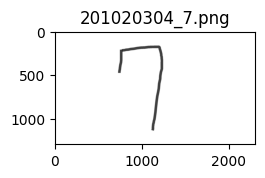

In [5]:
# PNG 파일을 그립니다.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

plt.figure(figsize=(15, 7))
for i in range(10):
  target_dir = '/content/our_mnist/7' #TODO: 대상 디렉토리 이름을 쓰세요.
  rand_file = random.choice(os.listdir(target_dir))
  img = mpimg.imread(os.path.join(target_dir, rand_file))
  plt.subplot(2, 5, 1) # 행은 두 개, 열은 다섯 개, 1로 시작하는 인덱스 기재
  plt.imshow(img)
  # TODO: 파일이름을 그림 제목으로 달아보세요.
  plt.title(rand_file)
plt.show()

## 우리가 그린 그림으로 훈련/테스트 데이터셋 만들기
2020 미만 학번: 훈련 / 2020 이상 학번: 테스트

In [6]:
# 이해하지 않아도 됩니다.

our_train_images = []
our_train_labels = []

our_test_images = []
our_test_labels = []

for i in range(10):
  for filename in os.listdir(f'our_mnist/{i}/'):
    if filename < '2020':
      our_train_images.append(image_prepare(f'our_mnist/{i}/' + filename))
      our_train_labels.append(i)
    else:
      our_test_images.append(image_prepare(f'our_mnist/{i}/' + filename))
      our_test_labels.append(i)

our_train_images = np.asarray(our_train_images)
our_train_labels = np.asarray(our_train_labels)
our_test_images = np.asarray(our_test_images)
our_test_labels = np.asarray(our_test_labels)

## TODO 2: 우리가 만든 데이터셋 살펴보기
아래 코드를 실행해보고 물음에 답하세요.

Q1: 훈련 이미지의 모양을 어떻게 해석할 수 있을까요? <br>
A1: 28*28 사이즈의 390개의 데이터가 있다.

Q2: 현재 훈련 레이블에 적합한 loss 함수는 무엇일까요? <br>
A2: Sparse Categorical Crossentropy



In [7]:
print(f'훈련 이미지 모양: {our_train_images.shape}')
print(f'훈련 레이블 내용: {our_train_labels}')

훈련 이미지 모양: (390, 28, 28, 1)
훈련 레이블 내용: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


## 훈련 데이터 무작위로 순서 바꾸기 (중요)
검증 데이터로 훈련 데이터의 20%를 사용하는 경우 훈련 데이터의 마지막 20%가 검증 데이터로 사용되는데 이렇게 되면 0부터 7까지로만 훈련하고, 8과 9가 검증 데이터로 활용되어 제대로 학습되지 않습니다. (훈련에 검증 데이터가 사용되지 않아 8과 9를 학습할 수 없음) 이를 방지하기 위해 훈련 데이터를 무작위로 섞습니다. (그림과 정답을 같은 순서로 섞어야 합니다.)

In [8]:
# 이미지와 레이블을 동일한 순서로 섞습니다.

idx = np.random.permutation(len(our_train_images))
our_train_images, our_train_labels = our_train_images[idx], our_train_labels[idx]

In [9]:
# 그림도 레이블과 동일한 순서로 섞였습니다.
print(f'순서를 섞은 후의 훈련 레이블 내용: {our_train_labels}')

순서를 섞은 후의 훈련 레이블 내용: [7 0 4 6 3 0 7 8 2 2 3 6 5 2 4 4 3 0 8 9 7 4 6 2 4 5 6 2 8 2 8 0 7 1 9 7 2
 8 9 2 7 2 4 5 4 5 3 2 3 8 8 6 5 2 1 1 2 7 7 1 5 4 6 2 3 3 1 0 5 8 2 5 9 2
 7 4 5 7 2 4 0 2 4 2 6 9 0 6 0 8 0 2 1 4 0 6 1 8 3 7 5 9 1 8 8 0 9 9 8 7 1
 4 5 8 7 8 7 3 5 8 4 1 4 2 3 3 4 5 0 2 8 3 7 1 0 4 1 4 6 3 7 0 7 6 2 2 6 8
 5 8 4 6 4 6 3 8 0 9 4 2 8 5 9 8 3 6 9 9 3 4 8 6 9 3 5 0 6 2 9 7 3 3 7 8 3
 0 1 8 1 7 6 2 9 5 9 6 6 5 2 0 9 6 4 5 8 5 3 7 5 2 6 3 9 4 7 2 6 9 1 5 6 4
 6 9 6 5 9 6 5 9 1 3 8 6 0 7 9 4 5 1 6 7 5 5 3 0 4 9 9 5 6 1 6 3 0 6 1 2 8
 2 0 3 0 3 4 6 2 7 9 9 7 4 3 1 4 7 1 2 4 3 1 7 1 0 8 5 1 2 5 0 5 7 2 8 7 6
 2 1 8 1 4 1 5 5 9 1 0 5 4 4 5 3 7 0 0 4 9 0 8 0 8 9 8 7 1 0 1 3 8 5 0 3 6
 8 7 1 3 0 4 4 3 6 8 0 9 1 6 0 1 0 2 9 2 9 7 5 7 3 4 9 9 1 4 6 7 7 3 2 7 0
 1 9 9 7 3 5 0 1 5 6 3 8 1 9 8 0 3 9 1 1]


## TODO 3: 모델 정의
MNIST에서 99% 이상의 정확도를 달성할 수 있는 모델입니다.<br>
입력층과 출력층 및 loss 함수만 기재하세요.


In [19]:
# 나중에 모델을 초기화할 때도 사용합니다.
from keras import models
from keras import layers

model = models.Sequential()

# MLP에서는 (784,)였으나 CNN에서는 ...
model.add(layers.Input(shape=(28,28,1)))

model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(layers.Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))

# 출력층 모양은 MLP와 동일합니다.
model.add(layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## 모델 훈련
우리가 만든 훈련데이터로 훈련해 봅니다.

In [11]:
from keras.callbacks import EarlyStopping

epochs = 10000
es = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(our_train_images, our_train_labels, epochs=epochs, callbacks=es, validation_split=0.2)

Epoch 1/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.0965 - loss: 2.3007 - val_accuracy: 0.1026 - val_loss: 2.2976
Epoch 2/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.2421 - loss: 2.1090 - val_accuracy: 0.4615 - val_loss: 1.5652
Epoch 3/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5190 - loss: 1.4016 - val_accuracy: 0.5000 - val_loss: 1.3822
Epoch 4/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6306 - loss: 1.1120 - val_accuracy: 0.6667 - val_loss: 1.0617
Epoch 5/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7771 - loss: 0.7170 - val_accuracy: 0.6538 - val_loss: 1.1388
Epoch 6/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7529 - loss: 0.6430 - val_accuracy: 0.7821 - val_loss: 0.6409
Epoch 7/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8764 - loss: 0.4189 - val_accuracy: 0.7692 - val_loss: 0.6779
Epoch 8/10000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9065 - loss: 0.3255 -

## TODO 4: 모델 평가
우리가 만든 테스트 데이터로 평가해 봅시다.

In [12]:
score = model.evaluate(our_test_images, our_test_labels , verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.6068801283836365
Test accuracy: 0.8153846263885498


6만장의 훈련 데이터를 지닌 MNIST에서는 99% 이상의 정확도를 보이는 모델이었는데<br>
우리가 그린 수백 장의 그림으로는 정확도가 만족스럽지 않습니다.

## TODO 5: ImageDataGenerator 설정
모델의 성능을 높이기 위해 더 많은 훈련 데이터가 필요해 보입니다.<br>
새로 그림을 그리는 것 대신 여러분의 그림에 변형을 가해 새로운 그림을 생성할 것입니다.<br>
다음 항목들을 참고하여 아래의 코드를 완성하세요.

1. 이미지를 최대 15도까지 무작위로 회전시키기
2. 이미지를 가로로 최대 10% 움직이기
3. 이미지를 세로로 최대 10% 움직이기
4. 숫자 이미지를 위, 아래로 뒤집는 것을 허용해도 될까요?
5. 숫자 이미지를 왼쪽, 오른쪽으로 뒤집는 것을 허용해도 될까요?

Hint: https://keras.io/ko/preprocessing/image/

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=True)

## TODO 6: Image 생성해보기
우선 훈련 데이터의 첫 번째 그림을 그려봅시다.

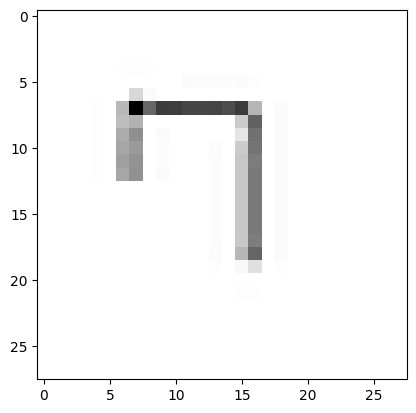

In [14]:
import matplotlib.pyplot as plt

first_img = our_train_images[0]
digit = first_img.reshape(28,28)
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

TODO 5에서 만든 datagen으로 다섯 장의 새 그림을 만들어봅시다.<br>
다양한 이미지가 정상적으로 그려지지 않는다면 datagen 만들 때 실수한 것은 아닌지 확인해보세요. <br> (<1인 실수와 >=1인 정수 기재 시 의미가 달라지는 옵션들이 있습니다.)

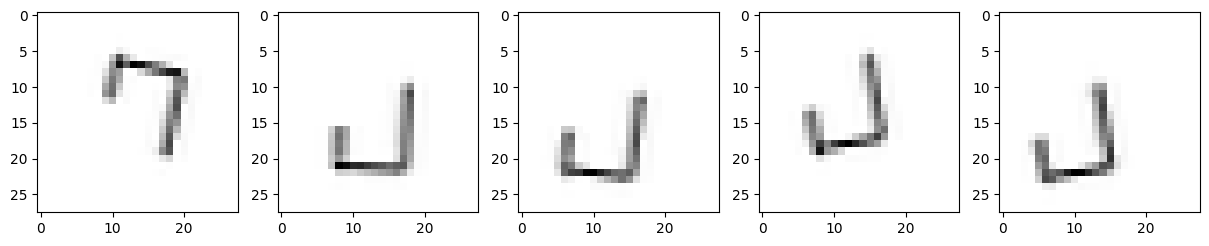

In [15]:
plt.figure(figsize=(15, 4))
for i in range(5):
  new_img = datagen.random_transform(our_train_images[0]) # random_transform 함수에 첫 번째 그림 입력하여 새 그림 생성
  plt.subplot(1,5,i+1) # 행 하나, 열 다섯 개, 1로 시작하는 인덱스
  plt.imshow(new_img.reshape(28,28), cmap=plt.cm.binary)
plt.show()

## TODO 7: 훈련 데이터 100배 늘리기
한 장의 훈련 이미지로 100장씩 생성해 봅시다.

In [16]:
# 빈 배열 만들기
augmented_train_images = np.empty((len(our_train_images)*100,28,28,1))
augmented_train_labels = np.empty(len(our_train_labels)*100)

# 배열 채우기, 훈련 데이터에서 한 장씩 꺼내 100개씩 만듭니다.
for i in range(len(our_train_images)):
  image = our_train_images[i]#TODO: 원본 이미지 지정
  label = our_train_labels[i]#TODO: 이미지의 답안 지정
  for j in range(100):
    augmented_train_images[i*100 + j] = datagen.random_transform(image)#TODO: datagen으로 생성한 이미지
    augmented_train_labels[i*100 + j] = label#TODO: 새로 생성한 이미지의 레이블

In [17]:
print(f'원본 이미지 모양: {our_train_images.shape}')
print(f'증강 이미지 모양: {augmented_train_images.shape}')

원본 이미지 모양: (390, 28, 28, 1)
증강 이미지 모양: (39000, 28, 28, 1)


## TODO 8: 증강한 훈련 데이터의 순서 섞기

In [18]:
#TODO: 순서를 섞어 보세요.
#Hint: TODO 2 아래 내용 참고
idx = np.random.permutation(len(augmented_train_images))
augmented_train_images, augmented_train_labels = augmented_train_images[idx], augmented_train_labels[idx]

## TODO 9: 모델 다시 정의하고 증강 데이터로 훈련하기
TODO 3의 코드를 다시 실행해서 모델을 초기화하고 아래 코드로 훈련합니다.

In [20]:
# TODO 3 코드를 먼저 실행하여 모델을 초기화한 후 실행하세요.
from keras.callbacks import EarlyStopping

epochs = 10000
batch_size = 128

# 검증 데이터에서 100% 정확도를 달성한 이후에도 계속 훈련하는 것을 방지하기 위해 val_loss 대신 val_accuracy 사용
es = EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True)

# 증강한 훈련 데이터를 사용합니다.
model.fit(augmented_train_images,augmented_train_labels, batch_size=batch_size, epochs=epochs, callbacks=es, validation_split=0.2)

Epoch 1/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.5988 - loss: 1.1580 - val_accuracy: 0.9469 - val_loss: 0.1611
Epoch 2/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9543 - loss: 0.1414 - val_accuracy: 0.9722 - val_loss: 0.0884
Epoch 3/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9759 - loss: 0.0843 - val_accuracy: 0.9806 - val_loss: 0.0649
Epoch 4/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.9889 - loss: 0.0426 - val_accuracy: 0.9960 - val_loss: 0.0168
Epoch 5/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9949 - loss: 0.0216 - val_accuracy: 0.9912 - val_loss: 0.0266
Epoch 6/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9939 - loss: 0.0206 - val_accuracy: 0.9976 - val_loss: 0.0100
Epoch 7/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9976 - loss: 0.0085 - val_accuracy: 0.9990 - val_loss: 0.0019
Epoch 8/10000
244/244 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9989 

## TODO 10: 증강 데이터로 훈련한 모델 테스트하기
우리가 직접 그린 그림만으로 훈련한 모델 (TODO 4)과 증강한 데이터로 훈련한 모델의 성능을 비교해 보세요.

In [21]:
# TODO 4의 코드를 복사하여 붙여넣고 실행하세요.
score = model.evaluate(our_test_images, our_test_labels , verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.14171184599399567
Test accuracy: 0.9769230484962463


## TODO 11: MNIST 불러와서 전처리하기
MNIST 데이터로 훈련한 모델은 우리가 직접 그린 그림을 잘 분류하지 못했습니다.<br>
그렇다면 우리가 직접 그린 그림으로 훈련한 모델은 MNIST 데이터를 잘 분류할까요?

In [22]:
from keras.datasets import mnist

# MNIST 테스트 데이터 불러오기 (X: 그림, y: 레이블)
_, (X_test, y_test) = mnist.load_data()

# Scale images to the [0, 1] range
X_test = X_test.astype("float32") / 255

# MLP를 사용할 때는 X_test가 (10000, 784)의 모양이었지만(=[10000장의 이미지, 각 그림은 784개의 픽셀])
# 현재는 이차원 흑백 이미지를 처리하는 CNN을 사용하고 있습니다. 어떤 모양으로 만들어야 할까요?
# Make sure images have shape (28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)#TODO

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## TODO 12: MNIST 테스트 데이터로 모델 평가
MNIST 데이터로 훈련하면 99% 이상의 정확도를 얻을 수 있지만 우리가 직접 그린 그림을 활용하여 훈련한 모델의 성능은 다음과 같습니다.

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 4.900724411010742
Test accuracy: 0.760200023651123


다음 노트북에서 MNIST와 우리가 그린 그림을 모두 잘 예측하는 모델을 만들어 봅시다.